## dependency

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import sys

sys.path.append("/content/drive/MyDrive/1k_project_WandB/")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install pynvml
!pip install torchmetrics
!sudo apt install zip pigz
!pip install pytorch_lightning
!pip install pytorchvideo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
import torch
import random
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import time
import pytorch_lightning as pl
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt
import os
import psutil
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns
from pynvml import (
    nvmlInit,
    nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo,
    nvmlShutdown,
)
import numpy as np
from pytorch_lightning.callbacks import ModelCheckpoint
import os
import torch
import psutil
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from pytorch_lightning.loggers import WandbLogger
from pynvml import (
    nvmlInit,
    nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo,
    nvmlShutdown,
)
from pytorch_lightning.callbacks import EarlyStopping

In [ ]:
from models.resnet50_lstm import Resnet50_LSTM
from models.resnet50_gru import Resnet50_GRU
from models.efficientNetB5_gru import EfficientNetB5_GRU
from models.efficientNetB5_lstm import EfficientNetB5_LSTM
from models.tecno import MultiStageModel
from models.tecno import SingleStageModel
from models.tecno import DilatedResidualLayer

from transform import SequenceTransform

## extract resize zip

In [ ]:
import os
import cv2
import numpy as np


def extract_and_resize_frames(video_path, output_folder, fps=2, size=(224, 224)):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(
        original_fps / fps
    )  # Extract 1 frame every frame_interval frames

    # Extract and resize frames
    frame_count = 0
    saved_frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frame at the desired fps
        if frame_count % frame_interval == 0:
            # Crop to square aspect ratio (1:1) if needed
            height, width = frame.shape[:2]
            target_ratio = size[0] / size[1]
            img_ratio = width / height
            if img_ratio != target_ratio:
                if img_ratio > target_ratio:
                    # Image is wider, crop width
                    new_width = int(height * target_ratio)
                    offset = (width - new_width) // 2
                    frame = frame[:, offset : offset + new_width]
                else:
                    # Image is taller, crop height
                    new_height = int(width / target_ratio)
                    offset = (height - new_height) // 2
                    frame = frame[offset : offset + new_height, :]

            # Resize to exact 224x224
            frame = cv2.resize(frame, size, interpolation=cv2.INTER_LANCZOS4)

            # Save frame
            frame_filename = os.path.join(
                output_folder, f"frame_{saved_frame_count:05d}.jpg"
            )
            cv2.imwrite(frame_filename, frame, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
            saved_frame_count += 1

        frame_count += 1

    cap.release()
    print(
        f"Extracted and resized {saved_frame_count} frames from {video_path} to {output_folder}"
    )


# Example usage
video_folder = "/content/drive/MyDrive/Phase/full_videos/Video"
output_root = "/content/drive/MyDrive/cataract_paper_aras_frames"

# Define the specific numbers you want to exclude
specific_numbers = [4693, 4750, 4687, 4697]
for video_file in os.listdir(video_folder):
    if video_file.endswith(".mp4"):
        # Check if "S2" is in the video filename
        if "S2" not in video_file:
            print(
                f"Skipping video {video_file} because it does not contain 'S2' in the filename."
            )
            continue

        video_id = video_file.split(".")[0]
        # Extract the numeric part of the filename (e.g., "1232" from "case_1232.mp4")
        video_id_number = video_file.split("_")[-1].split(".")[0]

        # Check if the video_id is a number and falls within the excluded range
        if video_id_number.isdigit() and int(video_id_number) in specific_numbers:
            print(
                f"Skipping video {video_file} because its ID {video_id_number} is in the excluded list."
            )
            continue  # Skip this video

        video_path = os.path.join(video_folder, video_file)
        output_folder = os.path.join(output_root, video_id)

        # Check if the output folder already exists
        if os.path.exists(output_folder) and os.listdir(output_folder):
            print(
                f"Skipping video {video_file} because output folder {output_folder} already exists and contains files."
            )
            continue  # Skip frame extraction for this video

        extract_and_resize_frames(video_path, output_folder, fps=4, size=(224, 224))

Skipping video PH_0002_S2_0002.mp4 because output folder /content/drive/MyDrive/cataract_paper_aras_frames/PH_0002_S2_0002 already exists and contains files.
Skipping video PH_0004_S2_0004.mp4 because output folder /content/drive/MyDrive/cataract_paper_aras_frames/PH_0004_S2_0004 already exists and contains files.


KeyboardInterrupt: 

In [ ]:
from PIL import Image
import os
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
import threading


def resize_image(file_info, size=(224, 224), counter=None, lock=None):
    input_path, output_path = file_info
    try:
        with Image.open(input_path) as img:
            # Convert to RGB if image is RGBA or other mode
            if img.mode in ("RGBA", "P"):
                img = img.convert("RGB")
            # Calculate aspect ratio
            img_ratio = img.width / img.height
            target_ratio = size[0] / size[1]
            if img_ratio != target_ratio:
                # Crop to match target aspect ratio
                if img_ratio > target_ratio:
                    # Image is wider, crop width
                    new_width = int(img.height * target_ratio)
                    offset = (img.width - new_width) // 2
                    img = img.crop((offset, 0, offset + new_width, img.height))
                else:
                    # Image is taller, crop height
                    new_height = int(img.width / target_ratio)
                    offset = (img.height - new_height) // 2
                    img = img.crop((0, offset, img.width, offset + new_height))
            # Resize to exact 224x224
            img = img.resize(size, Image.Resampling.LANCZOS)
            # Save with original format and maximum quality
            if img.format == "JPEG":
                img.save(output_path, "JPEG", quality=100, optimize=False)
            else:
                img.save(output_path, img.format or "PNG")
            # print(f"Resized: {os.path.basename(input_path)}")

            # Increment counter thread-safely and print progress
            if counter is not None and lock is not None:
                with lock:
                    counter.value += 1
                    if counter.value % 1000 == 0:
                        print(f"Processed {counter.value} images")
    except Exception as e:
        print(f"Error processing {os.path.basename(input_path)}: {e}")


def resize_images(input_folder, output_folder, size=(224, 224)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    file_list = []
    for root, _, files in os.walk(input_folder):
        rel_path = os.path.relpath(root, input_folder)
        if "S2" not in rel_path:
            print(f"skip{rel_path}")
            continue
        output_subfolder = os.path.join(output_folder, rel_path)
        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_subfolder, file)
                file_list.append((input_path, output_path))

    # Initialize thread-safe counter
    counter = multiprocessing.Value("i", 0)
    lock = threading.Lock()

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        executor.map(lambda x: resize_image(x, size, counter, lock), file_list)

    print(f"Finished processing {counter.value} images")


# Example usage
input_folder = (
    "/content/drive/MyDrive/cataract_paper_aras_frames"  # Replace with your folder path
)
output_folder = "/content/drive/MyDrive/cataract_paper_aras_frames_low_noor"  # Replace with output folder path
resize_images(input_folder, output_folder, size=(224, 224))

In [ ]:
import os
import zipfile


def zip_individual_folders(source_dir, output_dir):
    """
    Zip each subfolder in the source directory into separate zip files while maintaining the folder structure.
    Prints a message when each folder's zip file is completed.

    Args:
        source_dir (str): Path to the directory containing subfolders of images
        output_dir (str): Path to the directory where zip files will be saved
    """
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get list of subfolders in the source directory
    subfolders = [
        f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))
    ]

    for folder in subfolders:
        folder_path = os.path.join(source_dir, folder)
        zip_path = os.path.join(output_dir, f"{folder}.zip")

        # Create a ZipFile object for each subfolder
        with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
            # Walk through the subfolder
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    # Check if the file is an image (you can add more extensions as needed)
                    if file.lower().endswith((".png", ".jpg", ".jpeg", ".gif", ".bmp")):
                        # Get the full path of the file
                        file_path = os.path.join(root, file)
                        # Calculate the relative path to maintain folder structure
                        rel_path = os.path.relpath(file_path, source_dir)
                        # Add the file to the zip with its relative path
                        zipf.write(file_path, rel_path)
        print(f"Completed zipping folder '{folder}' into: {zip_path}")


# Example usage
source_directory = "/content/drive/MyDrive/cataract_paper_aras_frames_low_noor"  # Replace with your folder path in Colab
output_directory = "/content/drive/MyDrive/cataract_paper_zip_frames_low_noor"  # Output directory for zip files
zip_individual_folders(source_directory, output_directory)

Completed zipping folder 'PH_0002_S2_0002' into: /content/drive/MyDrive/cataract_paper_zip_frames_low_noor/PH_0002_S2_0002.zip
Completed zipping folder 'PH_0004_S2_0004' into: /content/drive/MyDrive/cataract_paper_zip_frames_low_noor/PH_0004_S2_0004.zip
Completed zipping folder 'PH_0003_S2_0003' into: /content/drive/MyDrive/cataract_paper_zip_frames_low_noor/PH_0003_S2_0003.zip
Completed zipping folder 'PH_0001_S2_0001' into: /content/drive/MyDrive/cataract_paper_zip_frames_low_noor/PH_0001_S2_0001.zip
Completed zipping folder 'PH_0005_S2_0005' into: /content/drive/MyDrive/cataract_paper_zip_frames_low_noor/PH_0005_S2_0005.zip
Completed zipping folder 'PH_0006_S2_0006' into: /content/drive/MyDrive/cataract_paper_zip_frames_low_noor/PH_0006_S2_0006.zip
Completed zipping folder 'PH_0007_S2_0007' into: /content/drive/MyDrive/cataract_paper_zip_frames_low_noor/PH_0007_S2_0007.zip
Completed zipping folder 'PH_0008_S2_0008' into: /content/drive/MyDrive/cataract_paper_zip_frames_low_noor/PH_0

## data preprocess paper

In [ ]:
import pandas as pd
import os


def parse_annotations(annotation_folders):
    annotations = {}
    # for annotation_folder in os.listdir(annotation_folders):
    #     annotation_folder_path = os.path.join(annotation_folders, annotation_folder)
    #     if annotation_folder.startswith("case"):
    for annotation_file in os.listdir(annotation_folder):

        if annotation_file.endswith(".csv"):
            video_id = annotation_file.split("_")[1]  # Extract video ID from filename
            annotation_path = os.path.join(annotation_folder, annotation_file)
            df = pd.read_csv(annotation_path)
            annotations[video_id] = df
    return annotations


# Example usage
annotation_folder = "/content/drive/MyDrive/1k_project_WandB/Annotation"
annotations = parse_annotations(annotation_folder)

In [ ]:
import os
import zipfile


def unzip_all_folders(zip_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for file in os.listdir(zip_dir):
        if file.endswith(".zip"):
            zip_path = os.path.join(zip_dir, file)
            folder_name = os.path.splitext(file)[0]
            extract_path = os.path.join(output_dir, folder_name)

            # if os.path.exists(extract_path):
            #     print(f"Skipping {file} (already extracted)")
            #     continue

            try:
                with zipfile.ZipFile(zip_path, "r") as zip_ref:
                    zip_ref.extractall(extract_path)
                print(f"Extracted {file} to {extract_path}")
            except Exception as e:
                print(f"Failed to extract {file}: {e}")

    print("Unzipping process completed!")


unzip_all_folders(
    zip_dir="/content/drive/MyDrive/cataract_paper_frames_low_noor_zip",
    output_dir="/content/cataract_paper_noor_frames_unzipped_test",
)

Extracted PH_0002_S2_0002.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0002_S2_0002
Extracted PH_0004_S2_0004.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0004_S2_0004
Extracted PH_0003_S2_0003.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0003_S2_0003
Extracted PH_0001_S2_0001.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0001_S2_0001
Extracted PH_0005_S2_0005.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0005_S2_0005
Extracted PH_0006_S2_0006.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0006_S2_0006
Extracted PH_0007_S2_0007.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0007_S2_0007
Extracted PH_0008_S2_0008.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0008_S2_0008
Extracted PH_0010_S2_0017.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0010_S2_0017
Extracted PH_0009_S2_0016.zip to /content/cataract_paper_noor_frames_unzipped_test/PH_0009_S2_0016
Extracted 

In [ ]:
import os


def map_frames_to_annotations(
    video_id, frames_folder, annotations, original_fps=30, target_fps=4
):
    # Check if folder exists
    if not os.path.exists(frames_folder):
        raise FileNotFoundError(f"Frames folder not found: {frames_folder}")

    if video_id not in annotations:
        print(f"No annotations found for video {video_id}")
        return

    df = annotations[video_id]
    frame_to_phase = {}

    # Iterate through each annotation
    for _, row in df.iterrows():
        start_frame = row["frame"]
        end_frame = row["end_frame"]
        phase = row["comment"]

        frame_interval = int(original_fps / target_fps)
        start_frame_target = (start_frame + frame_interval - 1) // frame_interval
        end_frame_target = end_frame // frame_interval

        # Assign phase to frames in this range
        for frame_idx in range(start_frame_target, end_frame_target + 1):
            frame_to_phase[frame_idx] = phase

    # Save frame-phase mapping to a file
    output_file = os.path.join(frames_folder, "frame_phase_mapping.txt")

    # Delete the file if it already exists
    if os.path.exists(output_file):
        os.remove(output_file)

    with open(output_file, "w") as f:
        for frame_idx, phase in sorted(frame_to_phase.items()):
            f.write(f"frame_{frame_idx:05d}.jpg {phase}\n")

    print(f"Saved frame-phase mapping for video {video_id} to {output_file}")


output_root = "/content/cataract_paper_noor_frames_unzipped_test"
# Example usage
for video_id in annotations:
    # Find first folder starting with PH_{video_id}
    matching_folders = [
        f for f in os.listdir(output_root) if f.startswith(f"PH_{video_id}")
    ]
    if not matching_folders:
        continue
        raise FileNotFoundError(
            f"No folder starting with PH_{video_id} found in {output_root}"
        )

    if not video_id.startswith("0018"):
        continue
    # Use the first matching folder
    frames_folder = os.path.join(output_root, matching_folders[0])
    map_frames_to_annotations(
        video_id, frames_folder, annotations, original_fps=25, target_fps=4
    )

Saved frame-phase mapping for video 0018 to /content/cataract_paper_noor_frames_unzipped_test/PH_0018_S2_0025/frame_phase_mapping.txt


In [ ]:
import os
import random
import shutil


def split_into_train_test(
    unzipped_dir, output_base_dir, train_count=80, random_seed=None
):
    """
    Split already unzipped folders into train and test sets

    Args:
        unzipped_dir: Path to your unzipped folders (output from your first code)
        output_base_dir: Base directory where train/test folders will be created
        train_count: Number of folders to include in train set
        random_seed: Optional random seed for reproducibility
    """
    # Set random seed for reproducibility
    if random_seed is not None:
        random.seed(random_seed)

    # Create train and test directories
    train_dir = os.path.join(output_base_dir, "train")
    test_dir = os.path.join(output_base_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get folders in sorted order to ensure consistency
    all_folders = sorted(
        [
            f
            for f in os.listdir(unzipped_dir)
            if os.path.isdir(os.path.join(unzipped_dir, f))
        ]
    )

    # Randomly select folders for train set
    random.shuffle(all_folders)
    train_folders = all_folders[:train_count]
    test_folders = all_folders[train_count:]

    print(f"\nSplitting {len(all_folders)} folders:")
    print(f"- Train: {len(train_folders)} folders")
    print(f"- Test: {len(test_folders)} folders")

    # Move folders to train directory
    print("\nMoving train folders...")
    for folder in train_folders:
        src = os.path.join(unzipped_dir, folder)
        dst = os.path.join(train_dir, folder)
        shutil.move(src, dst)
        print(f"Moved {folder} to train set")

    # Move folders to test directory
    print("\nMoving test folders...")
    for folder in test_folders:
        src = os.path.join(unzipped_dir, folder)
        dst = os.path.join(test_dir, folder)
        shutil.move(src, dst)
        print(f"Moved {folder} to test set")

    print("\nSplitting completed successfully!")
    print(f"Train data saved to: {train_dir}")
    print(f"Test data saved to: {test_dir}")


# Example usage - point to your existing unzipped folder
split_into_train_test(
    unzipped_dir="/content/cataract_paper_aras_frames_unzipped_validation",  # From your first code
    output_base_dir="/content/cataract_paper_aras_frames_split",
    train_count=80,
    random_seed=42,  # for reproducibility
)

## Dataset loading

In [ ]:
# Define transformations
transform_train = SequenceTransform(None, apply_augmentation=True)
transform_test = SequenceTransform(None, apply_augmentation=False)

NameError: name 'SequenceTransform' is not defined

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import random
from torchvision import transforms
from PIL import Image
import numpy as np


# for 1k folder structure
class SequentialSurgicalPhaseDatasetAugOverlap(Dataset):
    def __init__(
        self,
        label_to_idx,
        root_dirs,
        lookback_window=10,
        transform=None,
        max_sequences_per_phase=1000,
        overlap=0,
        aug=False,
        feature_dim=2560,
        frame_interval=1,
        test=True,
    ):
        if isinstance(root_dirs, str):
            self.root_dirs = [root_dirs]
        else:
            self.root_dirs = root_dirs

        self.lookback_window = lookback_window
        self.transform = transform
        self.max_sequences_per_phase = max_sequences_per_phase
        self.overlap = overlap
        self.aug = aug
        self.feature_dim = feature_dim
        self.frame_interval = frame_interval
        self.test = test
        self.frame_paths = []
        self.labels = []

        self.label_to_idx = label_to_idx

        for root_dir in self.root_dirs:
            if not os.path.exists(root_dir):
                print(f"Warning: Directory {root_dir} does not exist. Skipping.")
                continue

            for video_folder in os.listdir(root_dir):
                video_path = os.path.join(root_dir, video_folder)
                map = os.path.join(root_dir, video_folder)
                video_path = os.path.join(video_path, video_folder)

                if not os.path.isdir(video_path):
                    continue

                mapping_file = os.path.join(map, "frame_phase_mapping.txt")
                phase_mapping = {}
                if os.path.exists(mapping_file):
                    with open(mapping_file, "r") as f:
                        for line in f:
                            frame_name, phase = line.strip().split(" ", 1)
                            if phase in self.label_to_idx:
                                phase_mapping[frame_name] = self.label_to_idx[phase]

                frame_names = []
                frame_labels = []

                for frame_file in sorted(os.listdir(video_path)):
                    if frame_file.endswith(".jpg"):
                        frame_path = os.path.join(video_path, frame_file)
                        if frame_file in phase_mapping:
                            frame_names.append(frame_path)
                            label = phase_mapping[frame_file]
                            if isinstance(label, tuple):
                                label = label[0]
                            frame_labels.append(label)

                if frame_names:
                    self.frame_paths.append(frame_names)
                    self.labels.append(frame_labels)
        random.seed(42)  # For reproducibility
        self.balanced_sequences = self._balance_and_augment_sequences()

    def _balance_and_augment_sequences(self):
        sequences_per_label = {}
        max_sequences_per_label = {}

        for phase, label_info in self.label_to_idx.items():
            if isinstance(label_info, tuple):
                label_num, max_seq = label_info
                if (
                    label_num not in max_sequences_per_label
                    or max_seq > max_sequences_per_label[label_num]
                ):
                    max_sequences_per_label[label_num] = max_seq
            else:
                label_num = label_info
                if label_num not in max_sequences_per_label:
                    max_sequences_per_label[label_num] = self.max_sequences_per_phase

            if label_num not in sequences_per_label:
                sequences_per_label[label_num] = []

        # Step 1: Build all possible sequences for each video
        for video_idx in range(len(self.frame_paths)):
            video_length = len(self.frame_paths[video_idx])
            step = max(1, self.lookback_window * self.frame_interval - self.overlap)

            for start_idx in range(
                0, video_length - self.lookback_window * self.frame_interval + 1, step
            ):
                end_idx = start_idx + self.lookback_window * self.frame_interval - 1
                if end_idx < len(self.labels[video_idx]):
                    sequence_labels = [
                        self.labels[video_idx][i]
                        for i in range(start_idx, end_idx + 1, self.frame_interval)
                        if i < len(self.labels[video_idx])
                    ]
                    if len(set(sequence_labels)) == 1:
                        label = sequence_labels[0]
                        sequences_per_label[label].append((video_idx, start_idx, False))

                        if self.aug and not self.test:
                            sequences_per_label[label].append(
                                (video_idx, start_idx, True)
                            )

        # Step 2: Balance sequences and augment if needed
        balanced_sequences = []
        augmentation_counts = {}  # Track number of augmented sequences added per label
        for label_num, sequences in sequences_per_label.items():
            augmentation_counts[label_num] = 0
            max_seq = max_sequences_per_label.get(
                label_num, self.max_sequences_per_phase
            )

            if len(sequences) > max_seq:
                # Downsample if too many sequences
                sequences = random.sample(sequences, max_seq)
            elif len(sequences) < max_seq and self.aug:
                # Augment to reach max_seq
                shortfall = max_seq - len(sequences)
                if sequences:  # Only augment if there are sequences to duplicate
                    additional_sequences = random.choices(
                        [
                            (video_idx, start_idx, True)
                            for video_idx, start_idx, _ in sequences
                        ],
                        k=shortfall,
                    )
                    sequences.extend(additional_sequences)
                    augmentation_counts[label_num] = len(additional_sequences)

            balanced_sequences.extend(sequences)

        # Print sequence information
        self.print_sequence_info(
            sequences_per_label,
            max_sequences_per_label,
            balanced_sequences,
            augmentation_counts,
        )

        # random.shuffle(balanced_sequences)
        return balanced_sequences

    def print_sequence_info(
        self,
        sequences_per_label,
        max_sequences_per_label,
        balanced_sequences,
        augmentation_counts,
    ):
        print("Balancing sequences with the following configuration:")
        print(
            f"  Lookback window: {self.lookback_window}, Frame interval: {self.frame_interval}, Overlap: {self.overlap}"
        )
        print(f"  Augmentation enabled: {self.aug and not self.test}")
        print("  Maximum sequences per label:")
        for label_num, max_seq in max_sequences_per_label.items():
            phases = [
                phase
                for phase, info in self.label_to_idx.items()
                if (isinstance(info, tuple) and info[0] == label_num)
                or info == label_num
            ]
            print(f"    Label {label_num} ({', '.join(phases)}): {max_seq}")

        print("\nSequences before balancing (only single-label sequences):")
        for label_num, sequences in sequences_per_label.items():
            phases = [
                phase
                for phase, info in self.label_to_idx.items()
                if (isinstance(info, tuple) and info[0] == label_num)
                or info == label_num
            ]
            print(
                f"  Label {label_num} ({', '.join(phases)}): {len(sequences)} sequences"
            )

        print("\nSequences after balancing:")
        for label_num in sequences_per_label.keys():
            selected_sequences = [
                seq
                for seq in balanced_sequences
                if self.labels[seq[0]][
                    seq[1] + self.lookback_window * self.frame_interval - 1
                ]
                == label_num
            ]
            phases = [
                phase
                for phase, info in self.label_to_idx.items()
                if (isinstance(info, tuple) and info[0] == label_num)
                or info == label_num
            ]
            aug_count = augmentation_counts.get(label_num, 0)
            print(
                f"  Label {label_num} ({', '.join(phases)}): {len(selected_sequences)} sequences "
                f"(including {aug_count} additionally augmented)"
            )

        print(f"\nTotal balanced sequences: {len(balanced_sequences)}")

    def __getitem__(self, idx):
        video_idx, start_idx, is_augmented = self.balanced_sequences[idx]
        frames = []
        frames_path = []
        frame_numbers = []

        for i in range(
            start_idx,
            start_idx + self.lookback_window * self.frame_interval,
            self.frame_interval,
        ):
            if i >= len(self.frame_paths[video_idx]):
                frame_path = self.frame_paths[video_idx][-1]
                frame_num = len(self.frame_paths[video_idx]) - 1
            else:
                frame_path = self.frame_paths[video_idx][i]
                frame_num = i

                frame_file = os.path.basename(frame_path)
                try:
                    frame_num = int(frame_file.split("_")[-1].replace(".jpg", ""))
                except (ValueError, IndexError):
                    frame_num = i

            frame = Image.open(frame_path).convert("RGB")

            frames.append(frame)
            frames_path.append(frame_path)
            frame_numbers.append(frame_num)

        if is_augmented or not self.test:
            frames = transform_train(frames)
        else:
            frames = transform_test(frames)
        frames = torch.stack(frames)
        label = self.labels[video_idx][
            start_idx + self.lookback_window * self.frame_interval - 1
        ]
        frame_numbers = torch.tensor(frame_numbers)

        return frames, label, frames_path

    def __len__(self):
        return len(self.balanced_sequences)

In [ ]:
from IPython.display import Image, display

# Display image from a URL
display(
    Image(
        "/content/cataract_paper_noor_frames_unzipped_test/PH_0001_S2_0001/PH_0001_S2_0001/frame_00609.jpg"
    )
)

In [ ]:
# Create dataset
test_root_dir = "/content/cataract_paper_noor_frames_unzipped_test"


# Define label mapping paper
label_to_idx = {
    "Incision": 0,
    "Viscoelastic": 1,
    "Capsulorhexis": 2,
    "Hydrodissection": 3,
    "Phacoemulsification": 4,
    "IrrigationAspiration": 5,
    "CapsulePolishing": 6,
    "LensImplantation": 7,
    "LensPositioning": 8,
    "ViscoelasticSuction": 9,
    "AnteriorChamberFlushing": 1,
    "TonifyingAntibiotics": 10,
}

lookback_window = 10

test_dataset = SequentialSurgicalPhaseDatasetAugOverlap(
    label_to_idx,
    test_root_dir,
    lookback_window=lookback_window,
    max_sequences_per_phase=1500,
    overlap=0,
    frame_interval=1,
    transform=None,
    test=True,
)


# Create DataLoader
batch_size = 10
num_workers = 2
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)


# for m,j in train_loader:
#     print(m.shape)
#     break
print(test_dataset.__len__())

Balancing sequences with the following configuration:
  Lookback window: 10, Frame interval: 1, Overlap: 0
  Augmentation enabled: False
  Maximum sequences per label:
    Label 0 (Incision): 1500
    Label 1 (Viscoelastic, AnteriorChamberFlushing): 1500
    Label 2 (Capsulorhexis): 1500
    Label 3 (Hydrodissection): 1500
    Label 4 (Phacoemulsification): 1500
    Label 5 (IrrigationAspiration): 1500
    Label 6 (CapsulePolishing): 1500
    Label 7 (LensImplantation): 1500
    Label 8 (LensPositioning): 1500
    Label 9 (ViscoelasticSuction): 1500
    Label 10 (TonifyingAntibiotics): 1500

Sequences before balancing (only single-label sequences):
  Label 0 (Incision): 244 sequences
  Label 1 (Viscoelastic, AnteriorChamberFlushing): 94 sequences
  Label 2 (Capsulorhexis): 391 sequences
  Label 3 (Hydrodissection): 124 sequences
  Label 4 (Phacoemulsification): 821 sequences
  Label 5 (IrrigationAspiration): 391 sequences
  Label 6 (CapsulePolishing): 17 sequences
  Label 7 (LensImplan

## validation

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# The ValidationModule and strip_prefix functions are unchanged.
# You can copy them from the previous answer or use the ones here.
# ==============================================================================


class ValidationModule(pl.LightningModule):
    def __init__(self, model, num_classes, class_names=None):
        super().__init__()
        self.model = model
        self.num_classes = num_classes
        self.class_names = (
            class_names if class_names else [str(i) for i in range(num_classes)]
        )
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_precision_macro = Precision(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_recall_macro = Recall(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_f1_macro = F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_accuracy_per_class = Accuracy(
            task="multiclass", num_classes=num_classes, average=None
        )
        self.val_precision_per_class = Precision(
            task="multiclass", num_classes=num_classes, average=None
        )
        self.val_recall_per_class = Recall(
            task="multiclass", num_classes=num_classes, average=None
        )
        self.val_f1_per_class = F1Score(
            task="multiclass", num_classes=num_classes, average=None
        )
        self.val_conf_matrix = ConfusionMatrix(
            task="multiclass", num_classes=num_classes
        )
        self.metrics = []

    def forward(self, x):
        # x = x.permute(0, 2, 1, 3, 4)  # → (B, C, T, H, W)

        #     x = torch.cat([
        #     x,
        #     x[:, :, -1:, :, :].repeat(1, 1, 6, 1, 1)
        # ], dim=2)  # Now shape: [1, 3, 16, 224, 224]
        return self.model(x)

    def validation_step(self, batch, batch_idx):
        x, y, *z = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.val_precision_macro.update(preds, y)
        self.val_recall_macro.update(preds, y)
        self.val_f1_macro.update(preds, y)
        self.val_accuracy_per_class.update(preds, y)
        self.val_precision_per_class.update(preds, y)
        self.val_recall_per_class.update(preds, y)
        self.val_f1_per_class.update(preds, y)
        self.val_conf_matrix.update(preds, y)

    def _plot_confusion_matrix(self, conf_matrix_data, filename="confusion_matrix.png"):
        df_cm = pd.DataFrame(
            conf_matrix_data, index=self.class_names, columns=self.class_names
        )
        plt.figure(figsize=(12, 10))
        fig_ = sns.heatmap(df_cm, annot=True, cmap="Blues", fmt="g").get_figure()
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        fig_.savefig(filename, dpi=300, bbox_inches="tight")
        plt.close(fig_)

    def on_validation_epoch_end(self):
        metrics = {
            "accuracy": self.val_accuracy.compute().item(),
            "precision_macro": self.val_precision_macro.compute().item(),
            "recall_macro": self.val_recall_macro.compute().item(),
            "f1_score_macro": self.val_f1_macro.compute().item(),
            **{
                f"accuracy_class_{i}": val
                for i, val in enumerate(self.val_accuracy_per_class.compute().tolist())
            },
            **{
                f"precision_class_{i}": val
                for i, val in enumerate(self.val_precision_per_class.compute().tolist())
            },
            **{
                f"recall_class_{i}": val
                for i, val in enumerate(self.val_recall_per_class.compute().tolist())
            },
            **{
                f"f1_class_{i}": val
                for i, val in enumerate(self.val_f1_per_class.compute().tolist())
            },
        }
        self.metrics.append(metrics)
        conf_matrix_np = self.val_conf_matrix.compute().cpu().numpy()
        self._plot_confusion_matrix(
            conf_matrix_np, filename="temp_confusion_matrix.png"
        )
        self.val_accuracy.reset()
        self.val_precision_macro.reset()
        self.val_recall_macro.reset()
        self.val_f1_macro.reset()
        self.val_accuracy_per_class.reset()
        self.val_precision_per_class.reset()
        self.val_recall_per_class.reset()
        self.val_f1_per_class.reset()
        self.val_conf_matrix.reset()


def strip_prefix(state_dict, prefix="model."):
    return {k.replace(prefix, ""): v for k, v in state_dict.items()}


# ==============================================================================
# MODIFIED FUNCTION
# ==============================================================================
def validate_model(
    name,
    ckpt_path,
    model,
    dataloader,
    num_classes,
    output_dir="metrics_full_farabi",
    class_names=None,
    device="cuda",
):
    """
    Validates a single model, saves its metrics and confusion matrix to a specific folder.

    Args:
        name (str): A unique name for this validation run (e.g., model name).
        ckpt_path (str or Path): Path to the model checkpoint (.ckpt or .pth).
        model (nn.Module): An instantiated model architecture.
        dataloader (torch.utils.data.DataLoader): The validation dataloader.
        num_classes (int): The number of classes in the dataset.
        output_dir (str, optional): Folder to save the output files. Defaults to "results".
        class_names (list, optional): List of class names for the confusion matrix plot.
        device (str, optional): The device to run on ('cuda' or 'cpu'). Defaults to "cuda".

    Returns:
        pandas.DataFrame: A DataFrame containing the calculated metrics.
    """
    # --- 1. Create the output directory if it doesn't exist ---
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"Outputs will be saved to: {output_path.resolve()}")

    # Load checkpoint
    print(f"Loading checkpoint from: {ckpt_path}")
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    state_dict = checkpoint.get("state_dict", checkpoint)
    state_dict = strip_prefix(state_dict, prefix="model.")
    model.load_state_dict(state_dict, strict=True)
    model.eval()

    # Wrap model and run validation
    lightning_model = ValidationModule(model, num_classes, class_names=class_names).to(
        device
    )
    trainer = pl.Trainer(
        accelerator="gpu" if device == "cuda" else "cpu",
        devices=1,
        enable_checkpointing=False,
        enable_model_summary=False,
        logger=False,
    )
    print("Starting validation...")
    trainer.validate(lightning_model, dataloaders=dataloader)
    print("Validation finished.")

    # Collect metrics
    if not lightning_model.metrics:
        raise RuntimeError("Validation did not produce any metrics.")

    metrics = lightning_model.metrics[0]
    metrics["model_name"] = name
    df = pd.DataFrame([metrics])
    cols = ["model_name"] + [col for col in df.columns if col != "model_name"]
    df = df[cols]

    # --- 2. Construct final file paths using the output directory ---
    csv_output_filename = output_path / f"{name}_farabi_metrics.csv"
    df.to_csv(csv_output_filename, index=False)
    print(f"Metrics saved to {csv_output_filename}")

    # --- 3. Move and rename the confusion matrix into the output directory ---
    temp_cm_filename = "temp_confusion_matrix.png"
    final_cm_filename = output_path / f"{name}_confusion_matrix_farabi.png"
    if os.path.exists(temp_cm_filename):
        os.rename(temp_cm_filename, final_cm_filename)
        print(f"Confusion matrix saved to {final_cm_filename}")

    return df

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
import pandas as pd
from pathlib import Path


class ValidationModule(pl.LightningModule):
    def __init__(self, model, num_classes):
        super().__init__()
        self.model = model
        self.num_classes = num_classes
        # Metrics
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_precision = Precision(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_recall = Recall(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_f1 = F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.val_f1_per_class = F1Score(
            task="multiclass", num_classes=num_classes, average=None
        )
        self.metrics = []

    def forward(self, x):
        # x = x.permute(0, 2, 1, 3, 4)  # → (B, C, T, H, W)

        #     x = torch.cat([
        #     x,
        #     x[:, :, -1:, :, :].repeat(1, 1, 6, 1, 1)
        # ], dim=2)  # Now shape: [1, 3, 16, 224, 224]

        return self.model(x)

    def validation_step(self, batch, batch_idx):
        x, y, z = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.val_precision.update(preds, y)
        self.val_recall.update(preds, y)
        self.val_f1.update(preds, y)
        self.val_f1_per_class.update(preds, y)

    def on_validation_epoch_end(self):
        # Collect per-class F1 scores
        f1_per_class = self.val_f1_per_class.compute().tolist()
        metrics = {
            "accuracy": self.val_accuracy.compute().item(),
            "precision": self.val_precision.compute().item(),
            "recall": self.val_recall.compute().item(),
            "f1_score": self.val_f1.compute().item(),
            **{f"f1_class_{i}": f1 for i, f1 in enumerate(f1_per_class)},
        }
        self.metrics.append(metrics)
        # Reset metrics
        self.val_accuracy.reset()
        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1.reset()
        self.val_f1_per_class.reset()


def strip_prefix(state_dict, prefix="model."):
    return {k.replace(prefix, ""): v for k, v in state_dict.items()}


def validate_models(
    name, ckpt_path, model_architecture, dataloader, num_classes, device="cuda"
):
    # Store results for all models
    all_metrics = []

    # Initialize model (replace with your model architecture)
    # model = model_architecture()  # e.g., torchvision.models.resnet18(num_classes=num_classes)
    # Load checkpoint weights

    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    state_dict = checkpoint["state_dict"] if "state_dict" in checkpoint else checkpoint
    state_dict = strip_prefix(state_dict, prefix="model.")  # Adjust prefix as needed
    model.load_state_dict(
        state_dict, strict=True
    )  # strict=False ignores missing/unexpected keys

    model.eval()

    # Wrap model in LightningModule
    lightning_model = ValidationModule(model, num_classes).to(device)

    # Set up trainer
    trainer = pl.Trainer(
        accelerator="gpu" if device == "cuda" else "cpu",
        devices=1,
        enable_checkpointing=False,
        enable_model_summary=False,
        logger=False,
    )

    # Run validation
    trainer.validate(lightning_model, dataloaders=dataloader)

    # Collect metrics
    metrics = lightning_model.metrics[0]
    metrics["model"] = name  # Use checkpoint filename as identifier
    all_metrics.append(metrics)

    # Save metrics to CSV
    df = pd.DataFrame(all_metrics)
    df.to_csv(f"{name}_test_metrics_noor.csv", index=False)
    return df

## Video Models

In [ ]:
# Example usage
from torchvision.models.video import swin3d_t, r3d_18, mc3_18, r2plus1d_18, mvit_v1_b
from pytorchvideo.models.hub import slow_r50, x3d_xs

num_classes = 11  # Number of classes in your dataset


checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/swin3d_t/artifacts/SwinForVideoClassification-SwinForVideoClassification_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8592.ckpt"  # Adjust to your checkpoint directory
model = swin3d_t()  # progress=True shows download bar
model.head = torch.nn.Linear(model.head.in_features, num_classes)

results = validate_model("swin3d_t", checkpoint_paths, model, test_loader, num_classes)


checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/MC3_18/artifacts/MC3_18-MC3_18_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8443.ckpt"  # Adjust to your checkpoint directory
model = mc3_18()  # progress=True shows download bar
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

results = validate_model("mc3_18", checkpoint_paths, model, test_loader, num_classes)


checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/r2plus1d_18/artifacts/r2plus1d_18-r2plus1d_18_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8316.ckpt"  # Adjust to your checkpoint directory
model = r2plus1d_18()  # progress=True shows download bar
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

results = validate_model(
    "r2plus1d_18", checkpoint_paths, model, test_loader, num_classes
)


checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/slow_r50/artifacts/slow_r50-slow_r50_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8613.ckpt"  # Adjust to your checkpoint directory
model = slow_r50()  # progress=True shows download bar
model.blocks[-1].proj = torch.nn.Linear(model.blocks[-1].proj.in_features, num_classes)

results = validate_model("slow_r50", checkpoint_paths, model, test_loader, num_classes)


checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/R3D_18/artifacts/R3D_18-R3D_18_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8320.ckpt"  # Adjust to your checkpoint directory
model = r3d_18()  # progress=True shows download bar
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

results = validate_model("r3d_18", checkpoint_paths, model, test_loader, num_classes)


checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/x3d_xs/artifacts/x3d_xs-x3d_xs_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.7864.ckpt"  # Adjust to your checkpoint directory
model = x3d_xs()  # progress=True shows download bar
model.blocks[-1].proj = torch.nn.Linear(model.blocks[-1].proj.in_features, num_classes)


results = validate_model("x3d_xs", checkpoint_paths, model, test_loader, num_classes)

print(results)

Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/swin3d_t/artifacts/SwinForVideoClassification-SwinForVideoClassification_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8592.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/swin3d_t_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/swin3d_t_confusion_matrix_farabi.png
Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/MC3_18/artifacts/MC3_18-MC3_18_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8443.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/mc3_18_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/mc3_18_confusion_matrix_farabi.png
Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/r2plus1d_18/artifacts/r2plus1d_18-r2plus1d_18_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8316.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/r2plus1d_18_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/r2plus1d_18_confusion_matrix_farabi.png
Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/slow_r50/artifacts/slow_r50-slow_r50_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8613.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/slow_r50_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/slow_r50_confusion_matrix_farabi.png
Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/R3D_18/artifacts/R3D_18-R3D_18_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8320.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/r3d_18_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/r3d_18_confusion_matrix_farabi.png
Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/x3d_xs/artifacts/x3d_xs-x3d_xs_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.7864.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/x3d_xs_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/x3d_xs_confusion_matrix_farabi.png
  model_name  accuracy  precision_macro  recall_macro  f1_score_macro  \
0     x3d_xs  0.733348         0.623215      0.587047        0.570603   

   accuracy_class_0  accuracy_class_1  accuracy_class_2  accuracy_class_3  \
0           0.80303          0.444444          0.940613          0.484127   

   accuracy_class_4  ...  f1_class_1  f1_class_2  f1_class_3  f1_class_4  \
0          0.904354  ...    0.551302    0.751914    0.453532    0.925493   

   f1_class_5  f1_class_6  f1_class_7  f1_class_8  f1_class_9  f1_class_10  
0    0.781936    0.241935    0.609665    0.081081    0.552632     0.633205  

[1 rows x 49 columns]


In [ ]:
checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/mvit_v1_b/artifacts/mvit_v1_b-mvit_v1_b_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8612.ckpt"  # Adjust to your checkpoint directory
model = mvit_v1_b()  # progress=True shows download bar
model.head[1] = torch.nn.Linear(model.head[1].in_features, num_classes)


results = validate_model("mvit_v1_b", checkpoint_paths, model, test_loader, num_classes)

Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/mvit_v1_b/artifacts/mvit_v1_b-mvit_v1_b_lr_5e-05_wd_0.001-best-checkpoint:v0/f1_macro=0.8612.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/mvit_v1_b_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/mvit_v1_b_confusion_matrix_farabi.png


## Two Stage Models

In [ ]:
import torchvision.models as models

num_classes = 11  # Number of classes in your dataset
resnet_backbone = models.resnet50()
efficientnet_backbone = models.efficientnet_b5()

checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/Resnet50_lstm/artifacts/ResNet50_LSTM_new-ResNet50_LSTM_new_hiddenMLP_128_hiddenSEQ_256_lr_5e-05_wd_0.001_dr_0.5-best-checkpoint:v0/f1_macro=0.8364.ckpt"
model = Resnet50_LSTM(num_classes, 256, 0.5, 128)
results = validate_model(
    "resnet50_lstm", checkpoint_paths, model, test_loader, num_classes
)


checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/EfficientNetB5_lstm/artifacts/EfficientNetB5_LSTM-EfficientNetB5_LSTM_hiddenMLP_128_hiddenSEQ_256_lr_5e-05_wd_0.001_dr_0.5-best-checkpoint:v0/f1_macro=0.8400.ckpt"
model = EfficientNetB5_LSTM(num_classes, 256, 0.5, 128)
results = validate_model(
    "efficientnetb5_lstm", checkpoint_paths, model, test_loader, num_classes
)

checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/resnet50_gru/artifacts/Resnet50_GRU-Resnet50_GRU_hiddenMLP_128_hiddenSEQ_256_lr_5e-05_wd_0.001_dr_0.5-best-checkpoint:v0/f1_macro=0.8348.ckpt"
model = Resnet50_GRU(num_classes, 256, 0.5, 128)
results = validate_model(
    "resnet50_gru", checkpoint_paths, model, test_loader, num_classes
)


checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/EfficientNetB5_gru/artifacts/EfficientNetB5_GRU-EfficientNetB5_GRU_hiddenMLP_128_hiddenSEQ_256_lr_5e-05_wd_0.001_dr_0.5-best-checkpoint:v0/f1_macro=0.8321.ckpt"
model = EfficientNetB5_GRU(num_classes, 256, 0.5, 128)
results = validate_model(
    "efficientnetb5_gru", checkpoint_paths, model, test_loader, num_classes
)

Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/Resnet50_lstm/artifacts/ResNet50_LSTM_new-ResNet50_LSTM_new_hiddenMLP_128_hiddenSEQ_256_lr_5e-05_wd_0.001_dr_0.5-best-checkpoint:v0/f1_macro=0.8364.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/resnet50_lstm_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/resnet50_lstm_confusion_matrix_farabi.png


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/EfficientNetB5_lstm/artifacts/EfficientNetB5_LSTM-EfficientNetB5_LSTM_hiddenMLP_128_hiddenSEQ_256_lr_5e-05_wd_0.001_dr_0.5-best-checkpoint:v0/f1_macro=0.8400.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/efficientnetb5_lstm_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/efficientnetb5_lstm_confusion_matrix_farabi.png
Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/resnet50_gru/artifacts/Resnet50_GRU-Resnet50_GRU_hiddenMLP_128_hiddenSEQ_256_lr_5e-05_wd_0.001_dr_0.5-best-checkpoint:v0/f1_macro=0.8348.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/resnet50_gru_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/resnet50_gru_confusion_matrix_farabi.png


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/EfficientNetB5_gru/artifacts/EfficientNetB5_GRU-EfficientNetB5_GRU_hiddenMLP_128_hiddenSEQ_256_lr_5e-05_wd_0.001_dr_0.5-best-checkpoint:v0/f1_macro=0.8321.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/efficientnetb5_gru_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/efficientnetb5_gru_confusion_matrix_farabi.png


In [ ]:
import torchvision.models as models

num_classes = 11  # Number of classes in your dataset
resnet_backbone = models.resnet50()
efficientnet_backbone = models.efficientnet_b5()

checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/artifacts/resnet50_tecno-Training_resnet50_tecno_lr_0.0001_num_stages_1_num_layers_6_num_f_maps_256-best-checkpoint:v0/f1_macro=0.8297.ckpt"
model = MultiStageModel(resnet_backbone, 6, 1, 256, 2048, num_classes)
results = validate_model(
    "resnet50_tecno", checkpoint_paths, model, test_loader, num_classes
)


checkpoint_paths = "/content/drive/MyDrive/1k_project_WandB/best-checkpoint-epochepoch=002-val_f1val_eff_tecno/f1_macro=0.8287.ckpt"
model = MultiStageModel(efficientnet_backbone, 6, 1, 256, 2048, num_classes)
results = validate_model(
    "efficientnetb5_tecno", checkpoint_paths, model, test_loader, num_classes
)

num_stages_classification: 1, num_layers: 6, num_f_maps: 256, dim: 2048
Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/artifacts/resnet50_tecno-Training_resnet50_tecno_lr_0.0001_num_stages_1_num_layers_6_num_f_maps_256-best-checkpoint:v0/f1_macro=0.8297.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/resnet50_tecno_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/resnet50_tecno_confusion_matrix_farabi.png
num_stages_classification: 1, num_layers: 6, num_f_maps: 256, dim: 2048
Outputs will be saved to: /content/metrics_full_farabi
Loading checkpoint from: /content/drive/MyDrive/1k_project_WandB/best-checkpoint-epochepoch=002-val_f1val_eff_tecno/f1_macro=0.8287.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting validation...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation finished.
Metrics saved to metrics_full_farabi/efficientnetb5_tecno_farabi_metrics.csv
Confusion matrix saved to metrics_full_farabi/efficientnetb5_tecno_confusion_matrix_farabi.png


## weight downloader

In [ ]:
import wandb
import os
import pandas as pd

# Configuration
api_key = "bbaea226c9bafff9f976a02e7a8bea81a870d1a1"  # Replace with your W&B API key
entity = "amir-taslime-2001-"  # Your W&B username or team name
project = "phase-classification"  # Your W&B project name
run_id = "uey1r54p"  # The specific run ID to https://wandb.ai/amir-taslime-2001-/phase-classification/runs/jc5fuh8x
output_dir = "/content/drive/MyDrive/1k_project_WandB/Resnet50_tecno"  # Local folder to save the exported data

# Initialize W&B API
wandb.login(key=api_key)
api = wandb.Api()

# Construct run path
run_path = f"{entity}/{project}/{run_id}"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

try:
    # Access the run
    run = api.run(run_path)
    print(f"Accessing run: {run_path} (State: {run.state})")

    # Export metrics to CSV
    try:
        metrics = run.history()
        if not metrics.empty:
            metrics_file = os.path.join(output_dir, "metrics.csv")
            metrics.to_csv(metrics_file)
            print(f"Metrics saved to {metrics_file}")
        else:
            print("No metrics available for this run.")
    except Exception as e:
        print(f"Failed to export metrics: {e}")

    # Export system metrics to CSV
    try:
        system_metrics = run.history(stream="events")
        if not system_metrics.empty:
            system_metrics_file = os.path.join(output_dir, "system_metrics.csv")
            system_metrics.to_csv(system_metrics_file)
            print(f"System metrics saved to {system_metrics_file}")
        else:
            print("No system metrics available for this run.")
    except Exception as e:
        print(f"Failed to export system metrics: {e}")

    # Export config to JSON
    try:
        config = run.config
        if config:
            config_file = os.path.join(output_dir, "config.json")
            with open(config_file, "w") as f:
                json.dump(config, f, indent=4)
            print(f"Config saved to {config_file}")
        else:
            print("No config available for this run.")
    except Exception as e:
        print(f"Failed to export config: {e}")

    # Download all files associated with the run, including potential log files
    try:
        files = run.files()
        for file in files:
            file_path = os.path.join(output_dir, file.name)
            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            file.download(root=output_dir, replace=True)
            if "output.log" in file.name or "wandb-metadata.json" in file.name:
                print(f"Downloaded potential log file: {file_path}")
            else:
                print(f"Downloaded file: {file_path}")
    except Exception as e:
        print(f"Failed to download files: {e}")

    # Download artifacts
    try:
        for artifact in run.logged_artifacts():
            artifact_dir = os.path.join(output_dir, "artifacts", artifact.name)
            os.makedirs(artifact_dir, exist_ok=True)
            artifact.download(root=artifact_dir)
            print(f"Downloaded artifact: {artifact.name} to {artifact_dir}")
    except Exception as e:
        print(f"Failed to download artifacts: {e}")

except Exception as e:
    print(f"Failed to access run {run_path}: {e}")

# Finish the run
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amir-taslime-2001 (amir-taslime-2001-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Accessing run: amir-taslime-2001-/phase-classification/uey1r54p (State: finished)
Metrics saved to /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/metrics.csv
System metrics saved to /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/system_metrics.csv
Failed to export config: name 'json' is not defined
Downloaded file: /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/artifact/1796322992/wandb_manifest.json
Downloaded file: /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/artifact/1817765873/wandb_manifest.json
Downloaded file: /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/config.yaml
Downloaded file: /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/media/images/train/confusion_matrix_11_ddca1aa5af62da14366d.png
Downloaded file: /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/media/images/train/confusion_matrix_15_aedad9acca91e025e7af.png
Downloaded file: /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/media/images/train/confusion_mat

wandb: Downloading large artifact resnet50_tecno-Training_resnet50_tecno_lr_0.0001_num_stages_1_num_layers_6_num_f_maps_256-best-checkpoint:v0, 114.19MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:10.7 (10.7MB/s)


Downloaded artifact: resnet50_tecno-Training_resnet50_tecno_lr_0.0001_num_stages_1_num_layers_6_num_f_maps_256-best-checkpoint:v0 to /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/artifacts/resnet50_tecno-Training_resnet50_tecno_lr_0.0001_num_stages_1_num_layers_6_num_f_maps_256-best-checkpoint:v0


wandb:   1 of 1 files downloaded.  


Downloaded artifact: run-uey1r54p-history:v0 to /content/drive/MyDrive/1k_project_WandB/Resnet50_tecno/artifacts/run-uey1r54p-history:v0


In [ ]:
ckpt_path = "/content/drive/MyDrive/1k_project_WandB/Resnet50_lstm/artifacts/ResNet50_LSTM_new-ResNet50_LSTM_new_hiddenMLP_128_hiddenSEQ_256_lr_5e-05_wd_0.001_dr_0.5-best-checkpoint:v0/f1_macro=0.8364.ckpt"

checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
state_dict = checkpoint["state_dict"] if "state_dict" in checkpoint else checkpoint
state_dict.keys()

## analys results

--- Using provided class name mapping ---
--- Data Reshaped with Class Names ---
            model_name     score metric_type     class
0            mvit_v1_b  0.953390    accuracy  Incision
1             swin3d_t  0.906780    accuracy  Incision
2  efficientnetb5_lstm  0.923729    accuracy  Incision
3   efficientnetb5_gru  0.906780    accuracy  Incision
4             slow_r50  0.851695    accuracy  Incision




/tmp/ipython-input-8-1916170402.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  long_df['class'].fillna(class_numbers.apply(lambda x: f'Unknown Class {x}'), inplace=True)


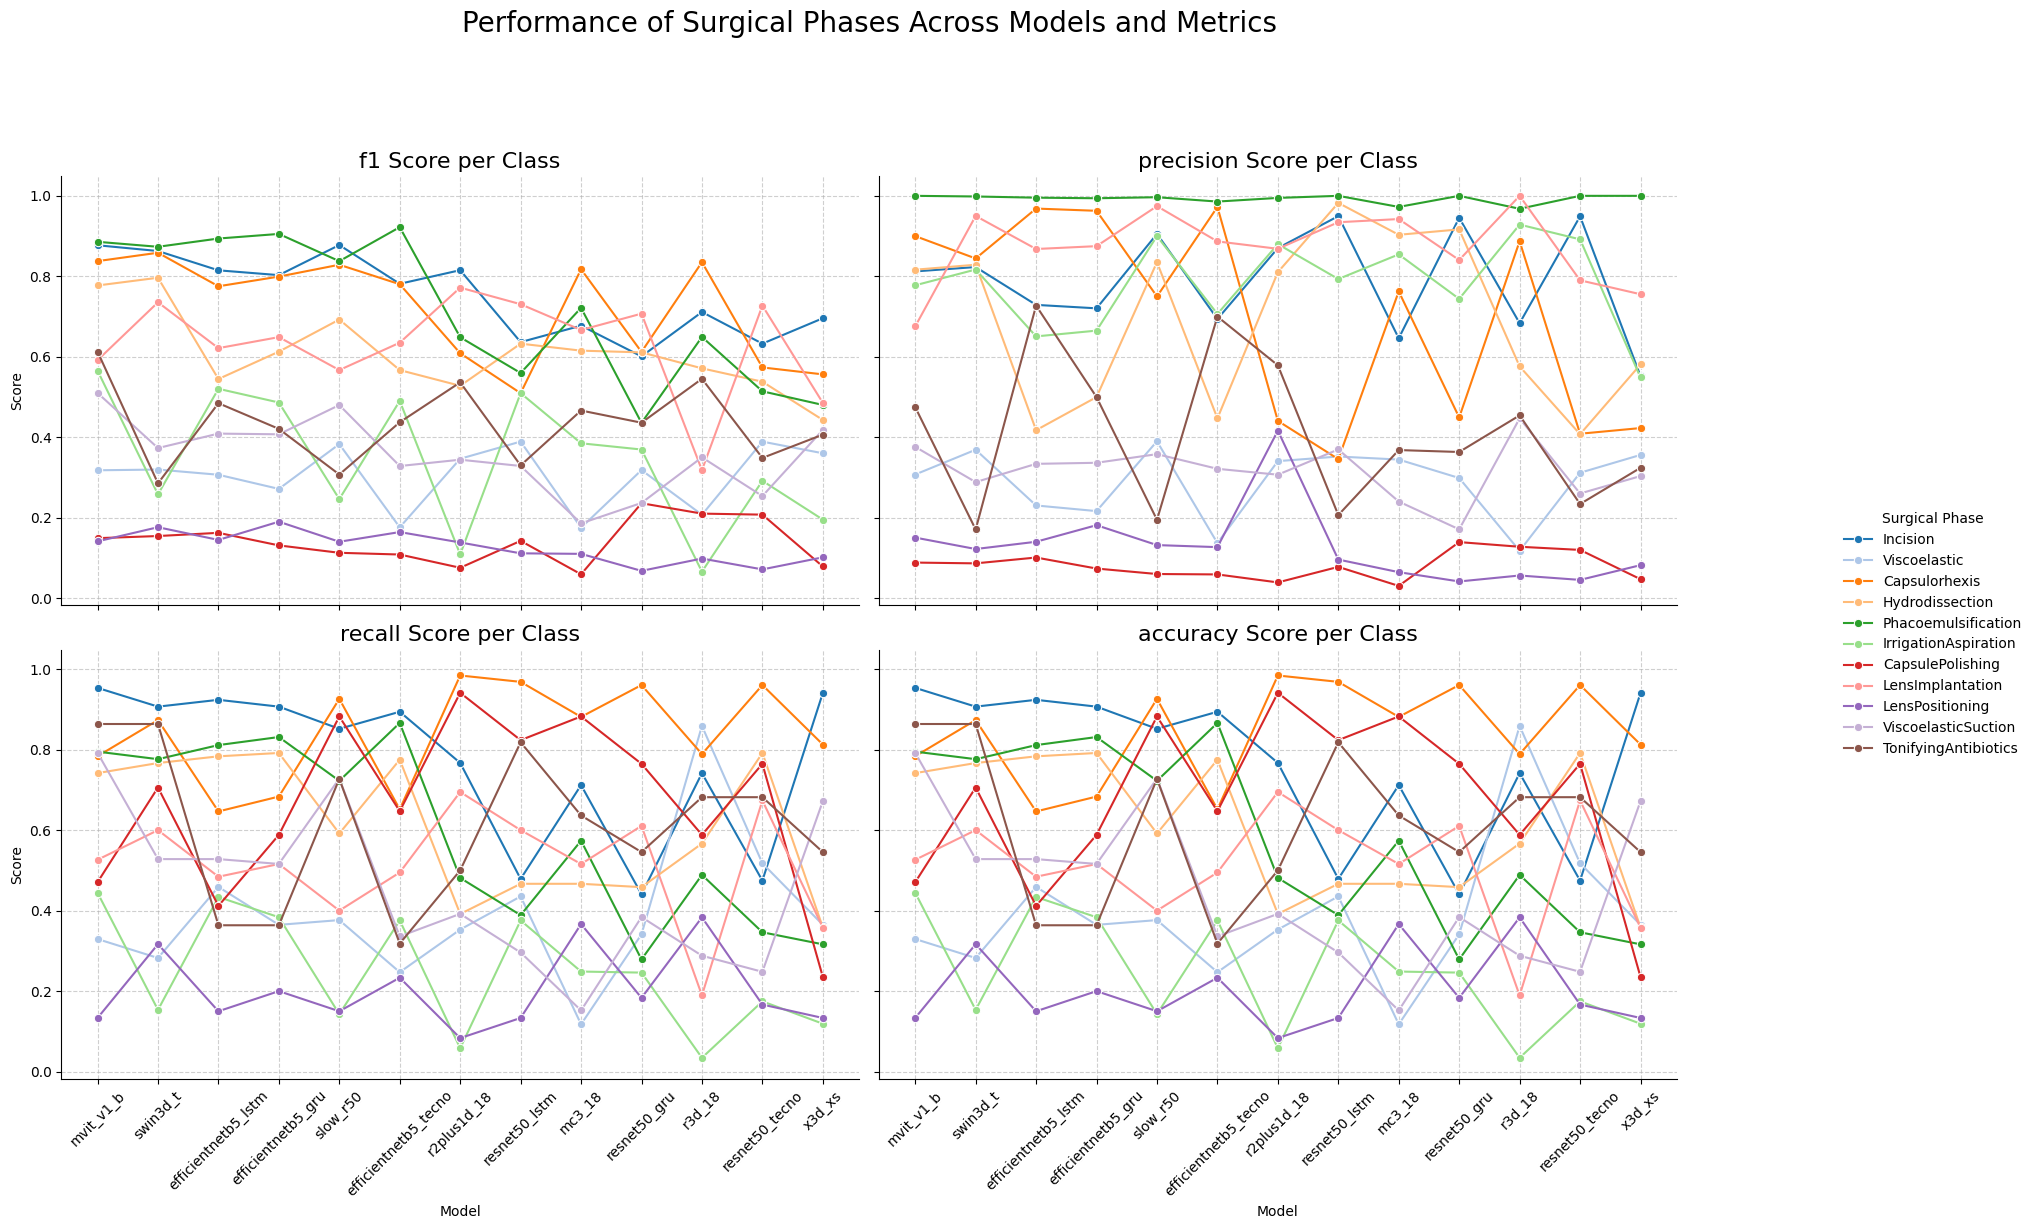

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# --- Configuration ---
# 1. SET THE PATH TO YOUR CSV FILE HERE
file_path = "farabi_metrics_all.csv"  # <--- CHANGE THIS TO YOUR FILENAME

# --- Main Plotting Function ---


def plot_class_performance_with_names(file_path):
    """
    Reads model metrics from a CSV and creates a 2x2 grid of line plots
    to visualize per-class performance, using meaningful class names from a
    provided mapping.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print(
            "Please make sure the script is in the same directory as your CSV or provide the full path."
        )
        return

    # --- NEW: Define the mapping from class number to class name ---
    # Based on the user-provided mapping.
    # Note: Class 1 is mapped to 'Viscoelastic' as it's the primary name for the combined class.
    class_map = {
        0: "Incision",
        1: "Viscoelastic",
        2: "Capsulorhexis",
        3: "Hydrodissection",
        4: "Phacoemulsification",
        5: "IrrigationAspiration",
        6: "CapsulePolishing",
        7: "LensImplantation",
        8: "LensPositioning",
        9: "ViscoelasticSuction",
        10: "TonifyingAntibiotics",
    }
    print("--- Using provided class name mapping ---")

    # 1. Reshape the data from wide to long format
    id_vars = ["model_name"]
    value_vars = [col for col in df.columns if re.search(r"_(class_\d+)", col)]

    if not value_vars:
        print("Error: Could not find per-class metric columns like 'f1_class_0', etc.")
        print("Please check your CSV file's column names.")
        return

    long_df = pd.melt(
        df,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name="metric_full",
        value_name="score",
    )

    # 2. Extract metric type and apply the class name mapping
    split_data = long_df["metric_full"].str.split("_class_", expand=True)
    long_df["metric_type"] = split_data[0]
    class_numbers = split_data[1].astype(int)

    # --- MODIFIED: Use the map to create the 'class' column ---
    # The .map() function efficiently applies the dictionary to the column.
    long_df["class"] = class_numbers.map(class_map)

    # Add a fallback for any class numbers in the data that are not in our map
    long_df["class"].fillna(
        class_numbers.apply(lambda x: f"Unknown Class {x}"), inplace=True
    )

    long_df = long_df.drop(columns=["metric_full"])

    # Ensure model names are treated as a categorical type for consistent ordering in plots
    long_df["model_name"] = pd.Categorical(
        long_df["model_name"], categories=df["model_name"].unique(), ordered=True
    )

    print("--- Data Reshaped with Class Names ---")
    print(long_df.head())
    print("\n" + "=" * 50 + "\n")

    # 3. Create the 2x2 grid of plots
    metrics_to_plot = ["f1", "precision", "recall", "accuracy"]
    plot_df = long_df[long_df["metric_type"].isin(metrics_to_plot)]

    # Use seaborn's FacetGrid
    # Using the 'tab20' palette which is good for many categories.
    g = sns.FacetGrid(
        plot_df,
        col="metric_type",
        col_wrap=2,
        hue="class",
        height=6,
        aspect=1.3,
        col_order=metrics_to_plot,
        palette="tab20",
    )

    # Map the line plot to the grid
    g.map(sns.lineplot, "model_name", "score", marker="o", sort=False)

    # 4. Customize the plots for clarity
    g.set_axis_labels("Model", "Score")
    g.set_titles(col_template="{col_name} Score per Class", size=16)

    # Adjust legend position and title
    g.add_legend(title="Surgical Phase", bbox_to_anchor=(1.05, 0.5), loc="center left")

    g.fig.suptitle(
        "Performance of Surgical Phases Across Models and Metrics", fontsize=20, y=1.02
    )

    # Rotate x-axis labels and add grid lines for better readability
    for ax in g.axes.flatten():
        if ax is not None:  # Check in case the grid is not full
            ax.tick_params(axis="x", rotation=45)
            ax.grid(True, linestyle="--", alpha=0.6)

    # Adjust layout to prevent labels/titles from overlapping
    plt.tight_layout(rect=[0, 0, 0.97, 0.95])  # Make space on the right for the legend
    plt.show()


# --- Run the plotting function ---
if __name__ == "__main__":
    plot_class_performance_with_names(file_path)

--- Data Reshaped Successfully ---
             model_name     score metric_type  class
0             mvit_v1_b  0.916667    accuracy      0
1              swin3d_t  0.882576    accuracy      0
2    efficientnetb5_gru  0.856061    accuracy      0
3  efficientnetb5_tecno  0.886364    accuracy      0
4   efficientnetb5_lstm  0.825758    accuracy      0


--- Analyzing: ACCURACY Score ---

[Summary for ACCURACY]
How many times each class had the LOWEST score across all models:
 Class  Times as Worst
     6               7
     8               6

How many times each class had the HIGHEST score across all models:
 Class  Times as Best
     4              6
     2              5
     5              1
     0              1


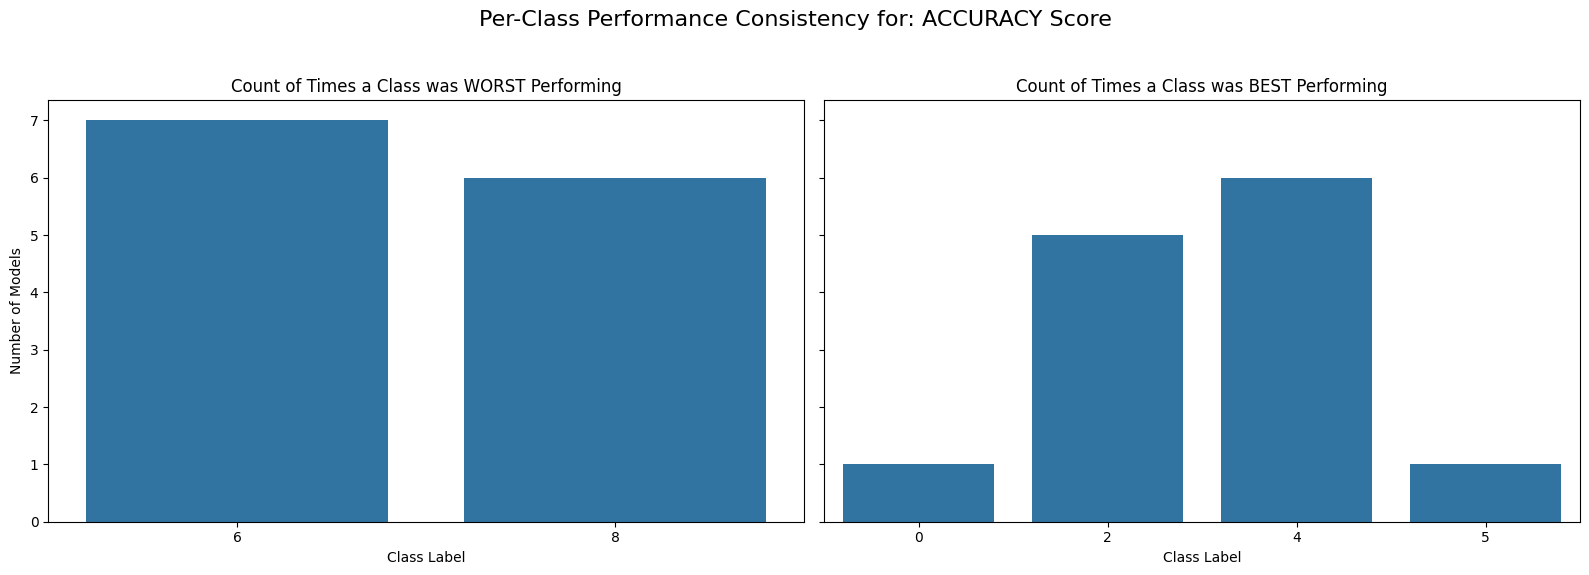



--- Analyzing: PRECISION Score ---

[Summary for PRECISION]
How many times each class had the LOWEST score across all models:
 Class  Times as Worst
     3               8
     6               5

How many times each class had the HIGHEST score across all models:
 Class  Times as Best
     4              9
     7              3
     5              1


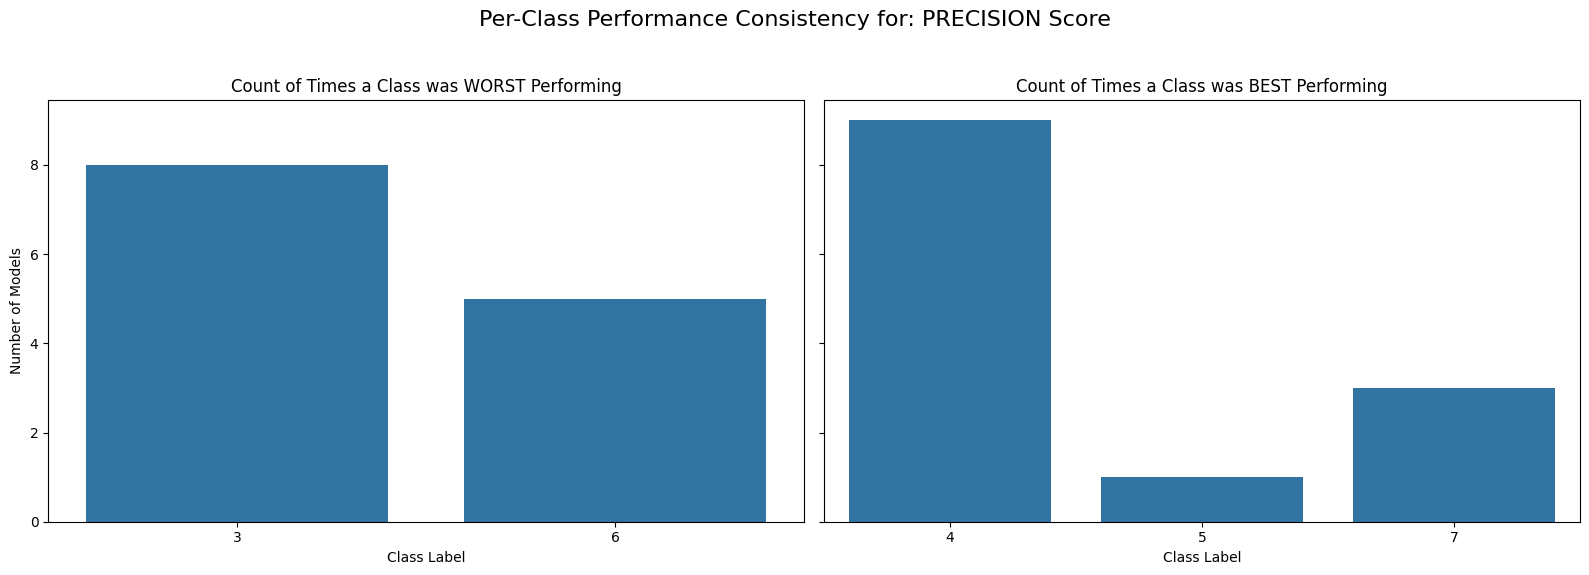



--- Analyzing: RECALL Score ---

[Summary for RECALL]
How many times each class had the LOWEST score across all models:
 Class  Times as Worst
     6               7
     8               6

How many times each class had the HIGHEST score across all models:
 Class  Times as Best
     4              6
     2              5
     5              1
     0              1


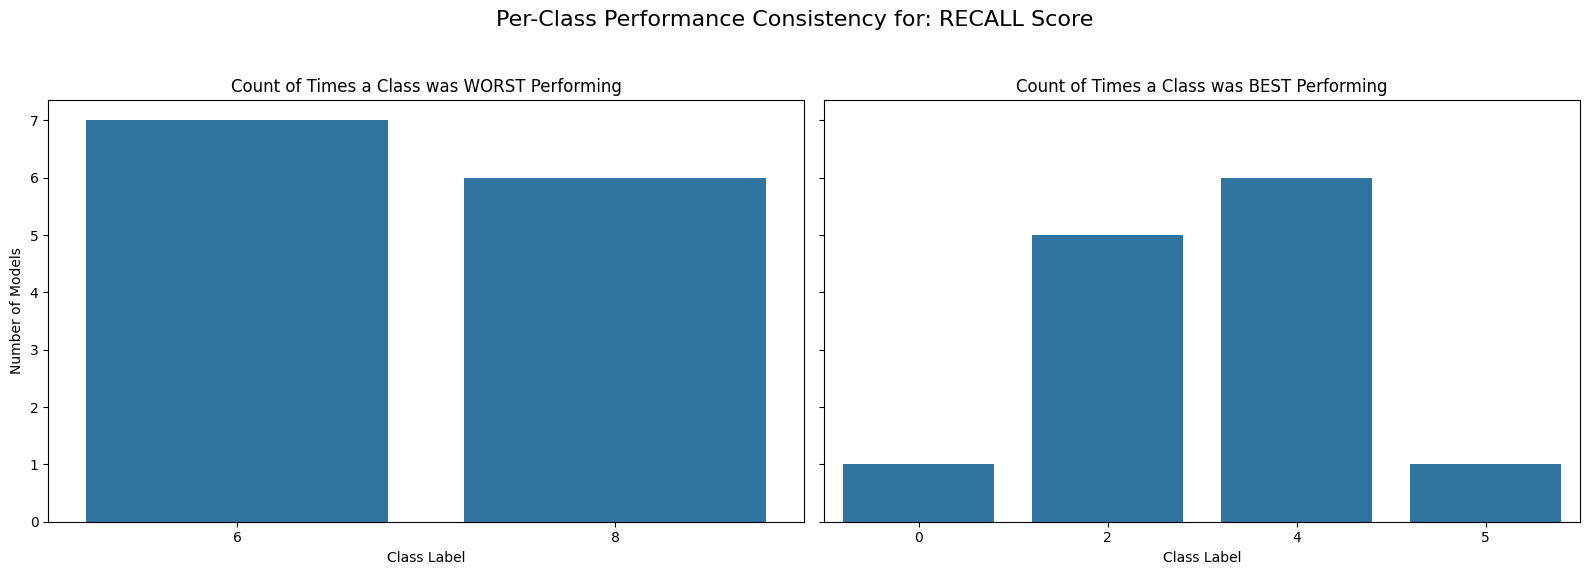



--- Analyzing: F1 Score ---

[Summary for F1]
How many times each class had the LOWEST score across all models:
 Class  Times as Worst
     6              10
     8               3

How many times each class had the HIGHEST score across all models:
 Class  Times as Best
     4             12
     5              1


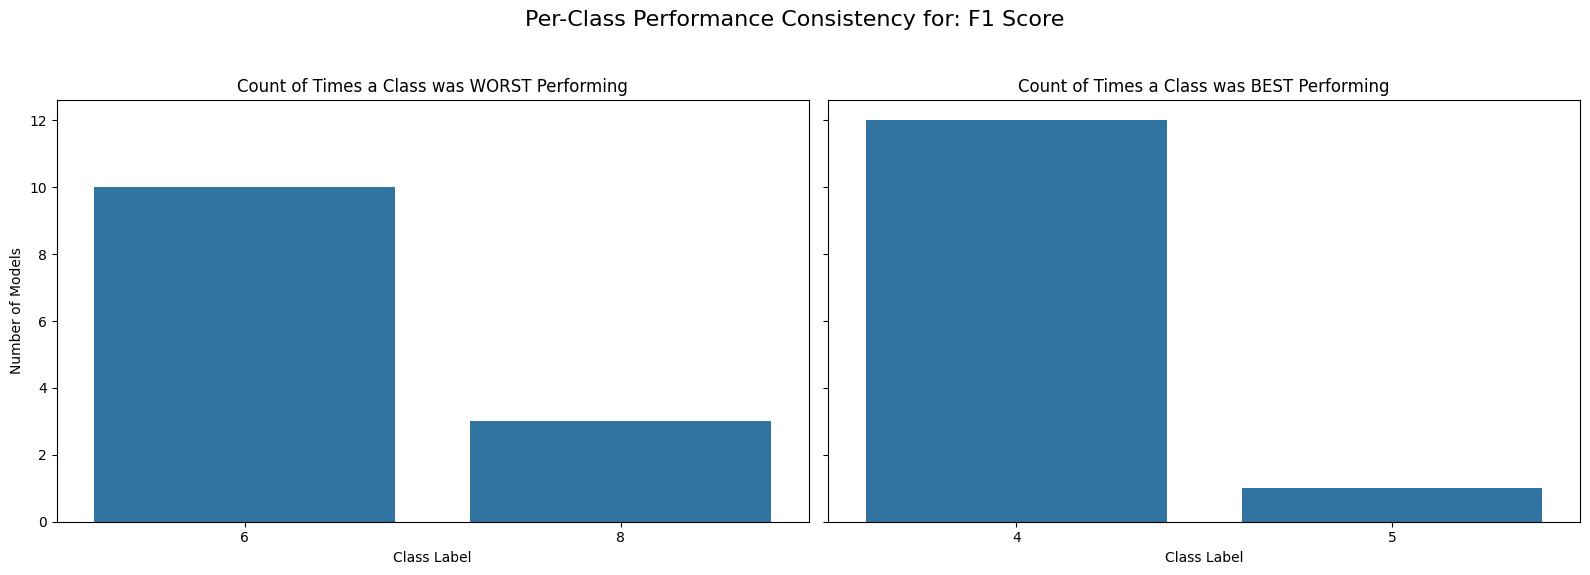

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

# --- Configuration ---
# 1. SET THE PATH TO YOUR CSV FILE HERE
file_path = "farabi_metrics_all.csv"  # <--- CHANGE THIS TO YOUR FILENAME

# --- Main Analysis Function ---


def analyze_model_metrics(file_path):
    """
    Analyzes model metrics from a CSV file to find consistent patterns
    in per-class performance across different models.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print(
            "Please make sure the script is in the same directory as your CSV or provide the full path."
        )
        return

    # 1. Reshape the data from wide to long format
    # This is the key step. We turn columns like 'f1_class_0', 'f1_class_1'
    # into rows, making them easy to group and compare.
    id_vars = ["model_name"]
    value_vars = [col for col in df.columns if re.search(r"_(class_\d+)", col)]

    if not value_vars:
        print(
            "Error: Could not find per-class metric columns like 'f1_class_0', 'precision_class_10', etc."
        )
        print("Please check your CSV file's column names.")
        return

    long_df = pd.melt(
        df,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name="metric_full",
        value_name="score",
    )

    # 2. Split the 'metric_full' column into 'metric_type' and 'class'
    # e.g., 'f1_class_10' -> metric_type='f1', class='10'
    split_data = long_df["metric_full"].str.split("_class_", expand=True)
    long_df["metric_type"] = split_data[0]
    long_df["class"] = split_data[1].astype(
        int
    )  # Convert class label to integer for proper sorting
    long_df = long_df.drop(columns=["metric_full"])

    print("--- Data Reshaped Successfully ---")
    print(long_df.head())
    print("\n" + "=" * 50 + "\n")

    # 3. Analyze each metric type (f1, precision, recall, accuracy)
    metrics_to_analyze = long_df["metric_type"].unique()

    for metric in metrics_to_analyze:
        print(f"--- Analyzing: {metric.upper()} Score ---")
        metric_df = long_df[long_df["metric_type"] == metric]

        # Find the worst performing class (minimum score) for each model
        worst_classes = metric_df.loc[metric_df.groupby("model_name")["score"].idxmin()]

        # Find the best performing class (maximum score) for each model
        best_classes = metric_df.loc[metric_df.groupby("model_name")["score"].idxmax()]

        # Count how many times each class was the worst or best
        worst_counts = worst_classes["class"].value_counts().reset_index()
        worst_counts.columns = ["Class", "Times as Worst"]

        best_counts = best_classes["class"].value_counts().reset_index()
        best_counts.columns = ["Class", "Times as Best"]

        print(f"\n[Summary for {metric.upper()}]")
        print("How many times each class had the LOWEST score across all models:")
        print(worst_counts.to_string(index=False))

        print("\nHow many times each class had the HIGHEST score across all models:")
        print(best_counts.to_string(index=False))

        # 4. Visualize the results
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
        fig.suptitle(
            f"Per-Class Performance Consistency for: {metric.upper()} Score",
            fontsize=16,
        )

        # Plot for worst counts
        sns.barplot(
            ax=axes[0],
            x="Class",
            y="Times as Worst",
            data=worst_counts.sort_values("Class"),
        )
        axes[0].set_title("Count of Times a Class was WORST Performing")
        axes[0].set_xlabel("Class Label")
        axes[0].set_ylabel("Number of Models")

        # Plot for best counts
        sns.barplot(
            ax=axes[1],
            x="Class",
            y="Times as Best",
            data=best_counts.sort_values("Class"),
        )
        axes[1].set_title("Count of Times a Class was BEST Performing")
        axes[1].set_xlabel("Class Label")
        axes[1].set_ylabel("")  # Hide y-label as it's shared

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        print("\n" + "=" * 50 + "\n")


# --- Run the analysis ---
if __name__ == "__main__":
    analyze_model_metrics(file_path)

## build test scores table

In [ ]:
import pandas as pd
from pathlib import Path
import os


def merge_csv_files(input_folder: str, output_file: str):
    """
    Finds all CSV files in an input folder, merges them into a single
    DataFrame, and saves the result to a new CSV file.

    This function assumes all input CSV files share the same columns.

    Args:
        input_folder (str): The path to the folder containing the CSV files.
        output_file (str): The path and filename for the merged output CSV file.
    """
    # Use pathlib for modern and easy path manipulation
    folder_path = Path(input_folder)

    # Check if the provided path is actually a directory
    if not folder_path.is_dir():
        print(f"Error: The specified folder '{input_folder}' does not exist.")
        return

    # Use glob to find all files ending with .csv in the specified folder
    csv_files = list(folder_path.glob("*.csv"))

    if not csv_files:
        print(f"No CSV files were found in the folder '{input_folder}'.")
        return

    print(f"Found {len(csv_files)} CSV files to merge:")
    for f in csv_files:
        print(f"  - {f.name}")

    # Create a list to hold the individual DataFrames
    list_of_dataframes = []

    # Loop through each CSV file path
    for file in csv_files:
        try:
            # Read the CSV into a DataFrame and add it to our list
            df = pd.read_csv(file)
            list_of_dataframes.append(df)
        except pd.errors.EmptyDataError:
            # This handles cases where a CSV file is empty
            print(f"Warning: Skipping empty file: {file.name}")
        except Exception as e:
            print(f"Warning: Could not read or process file {file.name}. Error: {e}")

    # If the list is empty after the loop (e.g., all files were empty or invalid), stop.
    if not list_of_dataframes:
        print("No valid data could be loaded. Aborting merge.")
        return

    # Concatenate all the DataFrames in the list into one
    # ignore_index=True will create a new clean index (0, 1, 2, ...) for the merged DataFrame
    print("\nMerging data...")
    merged_df = pd.concat(list_of_dataframes, ignore_index=True)

    # Optional but recommended: Sort the merged data by a key metric
    if "f1_score_macro" in merged_df.columns:
        merged_df = merged_df.sort_values(by="f1_score_macro", ascending=False)

    # Save the final merged DataFrame to the specified output file
    # index=False prevents pandas from writing the row index as a column in the CSV
    merged_df.to_csv(output_file, index=False)

    print(f"\nMerge complete! All data has been saved to '{output_file}'.")
    print(f"The final file has {len(merged_df)} rows.")


### Example Usage

if __name__ == "__main__":
    # --- 1. Setup for the example ---
    DUMMY_FOLDER = "/content/metrics_full_farabi"
    OUTPUT_FILENAME = "farabi_metrics.csv"

    # --- 2. Call the merge function ---
    # This is the main part. You provide the folder and the desired output file name.
    merge_csv_files(input_folder=DUMMY_FOLDER, output_file=OUTPUT_FILENAME)

Found 13 CSV files to merge:
  - efficientnetb5_tecno_farabi_metrics.csv
  - x3d_xs_farabi_metrics.csv
  - resnet50_tecno_farabi_metrics.csv
  - r2plus1d_18_farabi_metrics.csv
  - mc3_18_farabi_metrics.csv
  - efficientnetb5_lstm_farabi_metrics.csv
  - efficientnetb5_gru_farabi_metrics.csv
  - resnet50_gru_farabi_metrics.csv
  - slow_r50_farabi_metrics.csv
  - mvit_v1_b_farabi_metrics.csv
  - resnet50_lstm_farabi_metrics.csv
  - r3d_18_farabi_metrics.csv
  - swin3d_t_farabi_metrics.csv

Merging data...

Merge complete! All data has been saved to 'farabi_metrics.csv'.
The final file has 13 rows.


In [ ]:
!cp

In [ ]:
import pandas as pd
import glob
import os

# Set path to your folder containing CSV files
folder_path = "/content/drive/MyDrive/1k_project_WandB/results_csv"  # Replace with your actual path
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# This dictionary will store results like:
# {model_name: {'noor': [acc, prec, rec, f1], 'farabi': [...]}}
summary = {}

for file_path in csv_files:
    df = pd.read_csv(file_path)

    # Extract model name and dataset name
    filename = os.path.basename(file_path)
    if "noor" in filename:
        dataset = "noor"
    elif "farabi" in filename:
        dataset = "farabi"
    else:
        continue  # Skip if dataset name is not clear

    model_name = df.loc[0, "model"]
    metrics = df.loc[0, ["accuracy", "precision", "recall", "f1_score"]].tolist()

    if model_name not in summary:
        summary[model_name] = {}
    summary[model_name][dataset] = metrics

# Create a DataFrame from the summary dictionary
rows = []
for model, data in summary.items():
    row = [model]
    for dataset in ["noor", "farabi"]:
        if dataset in data:
            row.extend(data[dataset])
        else:
            row.extend([None] * 4)  # Fill missing datasets with None
    rows.append(row)

columns = [
    "Model",
    "Noor_Accuracy",
    "Noor_Precision",
    "Noor_Recall",
    "Noor_F1",
    "Farabi_Accuracy",
    "Farabi_Precision",
    "Farabi_Recall",
    "Farabi_F1",
]

summary_df = pd.DataFrame(rows, columns=columns)

# Optional: Save the result to CSV
summary_df.to_csv("summary_table.csv", index=False)

# Display
print(summary_df)

                   Model  Noor_Accuracy  Noor_Precision  Noor_Recall  \
0               swin3d_t       0.653328        0.582748     0.619755   
1                 mc3_18       0.511490        0.550755     0.504335   
2            r2plus1d_18       0.500792        0.585384     0.511361   
3               slow_r50       0.633914        0.592627     0.598526   
4                 r3d_18       0.474247        0.562591     0.511177   
5                 x3d_xs       0.459192        0.446207     0.441369   
6              mvit_v1_b       0.712758        0.584517     0.631480   
7          resnet50_lstm       0.490095        0.562642     0.529861   
8    efficientnetb5_lstm       0.657290        0.560593     0.548836   
9           resnet50_gru       0.438986        0.547132     0.482543   
10    efficientnetb5_gru       0.661252        0.550214     0.565466   
11        resnet50_tecno       0.462361        0.498977     0.532500   
12  efficientnetb5_tecno       0.641838        0.551270     0.53

In [ ]:
summary_df = summary_df.sort_values(by="Farabi_F1", ascending=False)

In [ ]:
summary_df

,Model,Noor_Accuracy,Noor_Precision,Noor_Recall,Noor_F1,Farabi_Accuracy,Farabi_Precision,Farabi_Recall,Farabi_F1
6,mvit_v1_b,0.712758,0.584517,0.631480,0.576131,0.857331,0.770883,0.785414,0.770955
0,swin3d_t,0.653328,0.582748,0.619755,0.522017,0.854693,0.775221,0.771855,0.761531
10,efficientnetb5_gru,0.661252,0.550214,0.565466,0.521259,0.820840,0.759853,0.703984,0.712640
12,efficientnetb5_tecno,0.641838,0.551270,0.537370,0.494767,0.817322,0.750880,0.712105,0.712371
8,efficientnetb5_lstm,0.657290,0.560593,0.548836,0.519080,0.815124,0.764143,0.694440,0.700143
3,slow_r50,0.633914,0.592627,0.598526,0.504738,0.796219,0.706543,0.712646,0.698215
9,resnet50_gru,0.438986,0.547132,0.482543,0.427781,0.797538,0.700530,0.704523,0.696680
1,mc3_18,0.511490,0.550755,0.504335,0.436286,0.787865,0.716558,0.695788,0.670243
7,resnet50_lstm,0.490095,0.562642,0.529861,0.447682,0.783689,0.714385,0.660214,0.669752
11,resnet50_tecno,0.462361,0.498977,0.532500,0.418483,0.770499,0.682349,0.691805,0.668681


from matplotlib import pyplot as plt
summary_df['Noor_Accuracy'].plot(kind='hist', bins=20, title='Noor_Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Noor_Precision'].plot(kind='hist', bins=20, title='Noor_Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Noor_Recall'].plot(kind='hist', bins=20, title='Noor_Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Noor_F1'].plot(kind='hist', bins=20, title='Noor_F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='Noor_Accuracy', y='Noor_Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='Noor_Precision', y='Noor_Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='Noor_Recall', y='Noor_F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df.plot(kind='scatter', x='Noor_F1', y='Farabi_Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Noor_Accuracy'].plot(kind='line', figsize=(8, 4), title='Noor_Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Noor_Precision'].plot(kind='line', figsize=(8, 4), title='Noor_Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Noor_Recall'].plot(kind='line', figsize=(8, 4), title='Noor_Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_df['Noor_F1'].plot(kind='line', figsize=(8, 4), title='Noor_F1')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import pandas as pd
import glob
import os

# Folder containing CSVs
folder_path = "/content/drive/MyDrive/1k_project_WandB/results_csv"  # Replace this

# Read all CSV files
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Prepare dictionary to collect results
results = {}

# Load each CSV and map to its dataset and model
for file in csv_files:
    df = pd.read_csv(file)
    model = df.loc[0, "model"]
    if "noor" in file:
        dataset = "noor"
    elif "farabi" in file:
        dataset = "farabi"
    else:
        continue
    metrics = df.loc[0, ["accuracy", "precision", "recall", "f1_score"]].tolist()
    if model not in results:
        results[model] = {}
    results[model][dataset] = metrics

# Define your models and their groups
model_order = [
    "video_transformer_header",
    "mvit_v1_b",
    "swin3d_t",
    "3d_cnns_header",
    "slow_r50",
    "mc3_18",
    "r3d_18",
    "x3d_xs",
    "r2plus1d_18",
    "cnn_rnn_hybrids_header",
    "efficientnetb5_gru",
    "efficientnetb5_tecno",
    "efficientnetb5_lstm",
    "resnet50_gru",
    "resnet50_lstm",
    "resnet50_tecno",
]

# Initialize rows
table_rows = []
for model in model_order:
    if model.endswith("_header"):
        header_text = {
            "video_transformer_header": "Video Transformers",
            "3d_cnns_header": "3D CNNs",
            "cnn_rnn_hybrids_header": "CNN-RNN Hybrids",
        }[model]
        table_rows.append([header_text, "", "", "", "", "", "", "", ""])
        continue

    row = [model]
    for dataset in ["noor", "farabi"]:
        if dataset in results.get(model, {}):
            row.extend([f"{x:.3f}" for x in results[model][dataset]])
        else:
            row.extend(["–"] * 4)
    table_rows.append(row)

# Create MultiIndex column
columns = pd.MultiIndex.from_tuples(
    [
        ("Model", ""),
        ("Noor", "Acc"),
        ("Noor", "Prec"),
        ("Noor", "Rec"),
        ("Noor", "F1"),
        ("Farabi", "Acc"),
        ("Farabi", "Prec"),
        ("Farabi", "Rec"),
        ("Farabi", "F1"),
    ]
)

# Final DataFrame
df_final = pd.DataFrame(table_rows, columns=columns)

# Save to LaTeX
latex_table = df_final.to_latex(
    index=False, multicolumn=True, multicolumn_format="c", bold_rows=False
)
with open("results_table.tex", "w") as f:
    f.write(latex_table)

# Preview
print(df_final)

                   Model   Noor                      Farabi                \
                            Acc   Prec    Rec     F1    Acc   Prec    Rec   
0     Video Transformers                                                    
1              mvit_v1_b  0.713  0.585  0.631  0.576  0.857  0.771  0.785   
2               swin3d_t  0.653  0.583  0.620  0.522  0.855  0.775  0.772   
3                3D CNNs                                                    
4               slow_r50  0.634  0.593  0.599  0.505  0.796  0.707  0.713   
5                 mc3_18  0.511  0.551  0.504  0.436  0.788  0.717  0.696   
6                 r3d_18  0.474  0.563  0.511  0.411  0.745  0.676  0.666   
7                 x3d_xs  0.459  0.446  0.441  0.383  0.733  0.623  0.587   
8            r2plus1d_18  0.501  0.585  0.511  0.442  0.642  0.666  0.570   
9        CNN-RNN Hybrids                                                    
10    efficientnetb5_gru  0.661  0.550  0.565  0.521  0.821  0.760  0.704   

In [ ]:
df_final

Model   Noor                      Farabi                \
                            Acc   Prec    Rec     F1    Acc   Prec    Rec   
0     Video Transformers                                                    
1              mvit_v1_b  0.713  0.585  0.631  0.576  0.857  0.771  0.785   
2               swin3d_t  0.653  0.583  0.620  0.522  0.855  0.775  0.772   
3                3D CNNs                                                    
4               slow_r50  0.634  0.593  0.599  0.505  0.796  0.707  0.713   
5                 mc3_18  0.511  0.551  0.504  0.436  0.788  0.717  0.696   
6                 r3d_18  0.474  0.563  0.511  0.411  0.745  0.676  0.666   
7                 x3d_xs  0.459  0.446  0.441  0.383  0.733  0.623  0.587   
8            r2plus1d_18  0.501  0.585  0.511  0.442  0.642  0.666  0.570   
9        CNN-RNN Hybrids                                                    
10    efficientnetb5_gru  0.661  0.550  0.565  0.521  0.821  0.760  0.704   
11  efficientnetb5_tecno  0.642  0.551  0.537  0.495  0.817  0.751  0.712   
12   efficientnetb5_lstm  0.657  0.561  0.549  0.519  0.815  0.764  0.694   
13          resnet50_gru  0.439  0.547  0.483  0.428  0.798  0.701  0.705   
14         resnet50_lstm  0.490  0.563  0.530  0.448  0.784  0.714  0.660   
15        resnet50_tecno  0.462  0.499  0.532  0.418  0.770  0.682  0.692   

           
       F1  
0          
1   0.771  
2   0.762  
3          
4   0.698  
5   0.670  
6   0.640  
7   0.571  
8   0.544  
9          
10  0.713  
11  0.712  
12  0.700  
13  0.697  
14  0.670  
15  0.669